In [1]:
import sys
sys.path.append('..')
from augmentations import *
from dataset import *
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torchvision.transforms import v2

c:\ProgramData\miniconda3\envs\hecto\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\ProgramData\miniconda3\envs\hecto\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.7'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# settings

In [2]:
# Hyperparameter Setting
CFG = {
    "ROOT": 'C:/Users/User/Desktop/competitions/hecto/data/train',
    "CUTMIX": {
        'enable': True,
        'params':{'alpha':1.0} # alpha값 float로 정의 안하면 오류남
    },
    "SALIENCYMIX": {
        'enable': False,
        'params':{'alpha':1.0, 'num_candidates':9}
    },
    "MIXUP": {
        'enable': True,
        'params':{'alpha':1.0} # alpha값 float로 정의 안하면 오류남
    },
    "MOSAIC": {
        'enable': True,
        'params':{
            'p': 1.0,
            'grid_size': 2,
            'use_saliency': True
        }
    },
    "CUTOUT": {
        'enable': False,
        'params':{
            'mask_size': 32
        }
    },

    # 기타 설정값들
    'IMG_SIZE': 640, # Number or Tuple(Height, Width)
    'BATCH_SIZE': 32
}

# transform

In [3]:
CFG['IMG_SIZE'] = CFG['IMG_SIZE'] if isinstance(CFG['IMG_SIZE'], tuple) else (CFG['IMG_SIZE'], CFG['IMG_SIZE'])
# --- Albumentations 기반 이미지 변환 정의 ---
train_transform = A.Compose([
    A.Lambda(name='half_crop', image=CustomCropTransform(p=0.5)),
    A.Resize(CFG['IMG_SIZE'][0], CFG['IMG_SIZE'][1]),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
    A.Affine(translate_percent=(0.1, 0.1), scale=(0.9, 1.1), shear=10, rotate=0, p=0.5),
    ToTensorV2()
])

# load data

In [4]:
train_root = CFG['ROOT']
initial_dataset = InitialCustomImageDataset(train_root)
if not initial_dataset.samples:
    raise ValueError(f"No images found in {train_root}. Please check the path and data structure.")
print(f"총 학습 이미지 수 (K-Fold 대상): {len(initial_dataset.samples)}")

all_samples = initial_dataset.samples
targets = [s[1] for s in all_samples]
class_names = initial_dataset.classes
num_classes = len(class_names)
print(f"클래스: {class_names} (총 {num_classes}개)")

총 학습 이미지 수 (K-Fold 대상): 33137
클래스: ['1시리즈_F20_2013_2015', '1시리즈_F20_2016_2019', '1시리즈_F40_2020_2024', '2008_2015_2017', '2시리즈_그란쿠페_F44_2020_2024', '2시리즈_액티브_투어러_F45_2019_2021', '2시리즈_액티브_투어러_U06_2022_2024', '3008_2세대_2018_2023', '3시리즈_E90_2005_2012', '3시리즈_F30_2013_2018', '3시리즈_G20_2019_2022', '3시리즈_G20_2023_2025', '3시리즈_GT_F34_2014_2021', '4시리즈_F32_2014_2020', '4시리즈_G22_2021_2023', '4시리즈_G22_2024_2025', '5008_2세대_2018_2019', '5008_2세대_2021_2024', '5시리즈_F10_2010_2016', '5시리즈_G30_2017_2023', '5시리즈_G60_2024_2025', '5시리즈_GT_F07_2010_2017', '6시리즈_F12_2011_2018', '6시리즈_GT_G32_2018_2020', '6시리즈_GT_G32_2021_2024', '718_박스터_2017_2024', '718_카이맨_2017_2024', '7시리즈_F01_2009_2015', '7시리즈_G11_2016_2018', '7시리즈_G11_2019_2022', '7시리즈_G70_2023_2025', '8시리즈_G15_2020_2024', '911_2003_2019', '911_992_2020_2024', 'A4_B9_2016_2019', 'A4_B9_2020_2024', 'A5_F5_2019_2024', 'A6_C8_2019_2025', 'A7_2012_2016', 'A7_4K_2020_2024', 'A8_D5_2018_2023', 'AMG_GT_2016_2024', 'A_클래스_W176_2015_2018', 'A_클래스_W177_2020_2025

In [5]:
train_dataset = FoldSpecificDataset(all_samples, image_size = CFG['IMG_SIZE'], transform=train_transform, is_train=False)
train_loader = DataLoader(train_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True, num_workers=2, pin_memory=True)

# check images

In [6]:
# cutmix or mixup transform settings
if CFG['CUTMIX']['enable'] and CFG["MIXUP"]['enable']:
    cutmix = v2.CutMix(num_classes=num_classes, **CFG['CUTMIX']['params'])
    mixup = v2.MixUp(num_classes=num_classes, **CFG['MIXUP']['params'])
    cutmix_or_mixup = v2.RandomChoice([cutmix, mixup])
    print("매 배치마다 CUTMIX와 MIXUP을 랜덤하게 적용합니다. CFG를 확인하세요.")
elif CFG['CUTMIX']['enable']:
    cutmix_or_mixup = v2.CutMix(num_classes=num_classes, **CFG['CUTMIX']['params'])
    print("매 배치마다 CUTMIX를 랜덤하게 적용합니다. CFG를 확인하세요.")
elif CFG["MIXUP"]['enable']:
    cutmix_or_mixup = v2.MixUp(num_classes=num_classes, **CFG['MIXUP']['params'])
    print("매 배치마다 MIXUP을 랜덤하게 적용합니다. CFG를 확인하세요.")
else:
    cutmix_or_mixup = None

# 복잡한 augmentation의 경우 여러개 선택 시 하나만 적용하기 위한 list
target_augmentations = ["CUTMIX", "MIXUP", "MOSAIC", "CUTOUT", "SALIENCYMIX"]
selected_augmentations = [i for i in target_augmentations if CFG[i]['enable']]

매 배치마다 CUTMIX와 MIXUP을 랜덤하게 적용합니다. CFG를 확인하세요.


In [11]:
def show_transformed_vs_original(dataloader, num_samples=4, device='cpu'):
    """
    무작위 배치 하나에서 num_samples만큼의 이미지에 대해
    원본 이미지와 transform된 이미지를 나란히 시각화.

    Args:
        dataloader: PyTorch DataLoader
        num_samples: 시각화할 이미지 수
        device: 'cuda' 또는 'cpu'
    """
    # dataloader에서 배치 하나만 추출
    for images, labels, img_paths in dataloader:
        images = images.to(device)
        num_samples = min(num_samples, images.size(0))
        
        if selected_augmentations:
            choice = random.choice(selected_augmentations)
            if choice == "NONE":
                choice = None
        else:
            choice = None
            
        # cutout을 위해 추가
        if CFG['CUTOUT']['enable'] and choice == 'CUTOUT':
            images = apply_cutout(images, **CFG['CUTOUT']['params'])
        
        # cutmix mixup을 위해 추가
        if cutmix_or_mixup and (choice == 'MIXUP' or choice == 'CUTMIX'):
            images, labels = cutmix_or_mixup(images, labels)
        
        # MOSAIC을 위해 추가
        if CFG['MOSAIC']['enable'] and (choice == 'MOSAIC'):
            images, labels = apply_mosaic(images, labels, num_classes, **CFG['MOSAIC']['params'])
        
        # SaliencyMix를 위해 추가
        if choice == 'SALIENCYMIX' and CFG['SALIENCYMIX']:
            images, labels = saliencymix(images, labels, num_classes, **CFG['SALIENCYMIX']['params'])

        fig, axs = plt.subplots(num_samples, 2, figsize=(10, 5 * num_samples))

        if num_samples == 1:
            axs = [axs]

        for i in range(num_samples):
            # transform된 이미지 (Tensor → numpy)
            print(img_paths[i])
            transformed_img = images[i].cpu()
            transformed_np = transformed_img.permute(1, 2, 0).numpy()

            # 원본 이미지 (img_path에서 로드)
            original_img = Image.open(img_paths[i]).convert('RGB')

            axs[i][0].imshow(original_img)
            axs[i][0].set_title(f"Original: {img_paths[i].split('/')[-1]}")
            axs[i][0].axis('off')

            axs[i][1].imshow(transformed_np)
            axs[i][1].set_title("Transformed")
            axs[i][1].axis('off')

        plt.tight_layout()
        plt.show()
        break

C:/Users/User/Desktop/competitions/hecto/data/train\LF_쏘나타_2015_2017\LF_쏘나타_2015_2017_0004.jpg
C:/Users/User/Desktop/competitions/hecto/data/train\쿠퍼_컨버터블_2016_2024\쿠퍼_컨버터블_2016_2024_0041.jpg
C:/Users/User/Desktop/competitions/hecto/data/train\아이오닉_하이브리드_2016_2019\아이오닉_하이브리드_2016_2019_0018.jpg
C:/Users/User/Desktop/competitions/hecto/data/train\더_뉴_아이오닉_하이브리드_2020\더_뉴_아이오닉_하이브리드_2020_0037.jpg


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_14192\1615765689.py:61: UserWarning: Glyph 50136 (\N{HANGUL SYLLABLE SSO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_14192\1615765689.py:61: UserWarning: Glyph 45208 (\N{HANGUL SYLLABLE NA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_14192\1615765689.py:61: UserWarning: Glyph 53440 (\N{HANGUL SYLLABLE TA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_14192\1615765689.py:61: UserWarning: Glyph 53216 (\N{HANGUL SYLLABLE KU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_14192\1615765689.py:61: UserWarning: Glyph 54140 (\N{HANGUL SYLLABLE PEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_14192\1615765689.

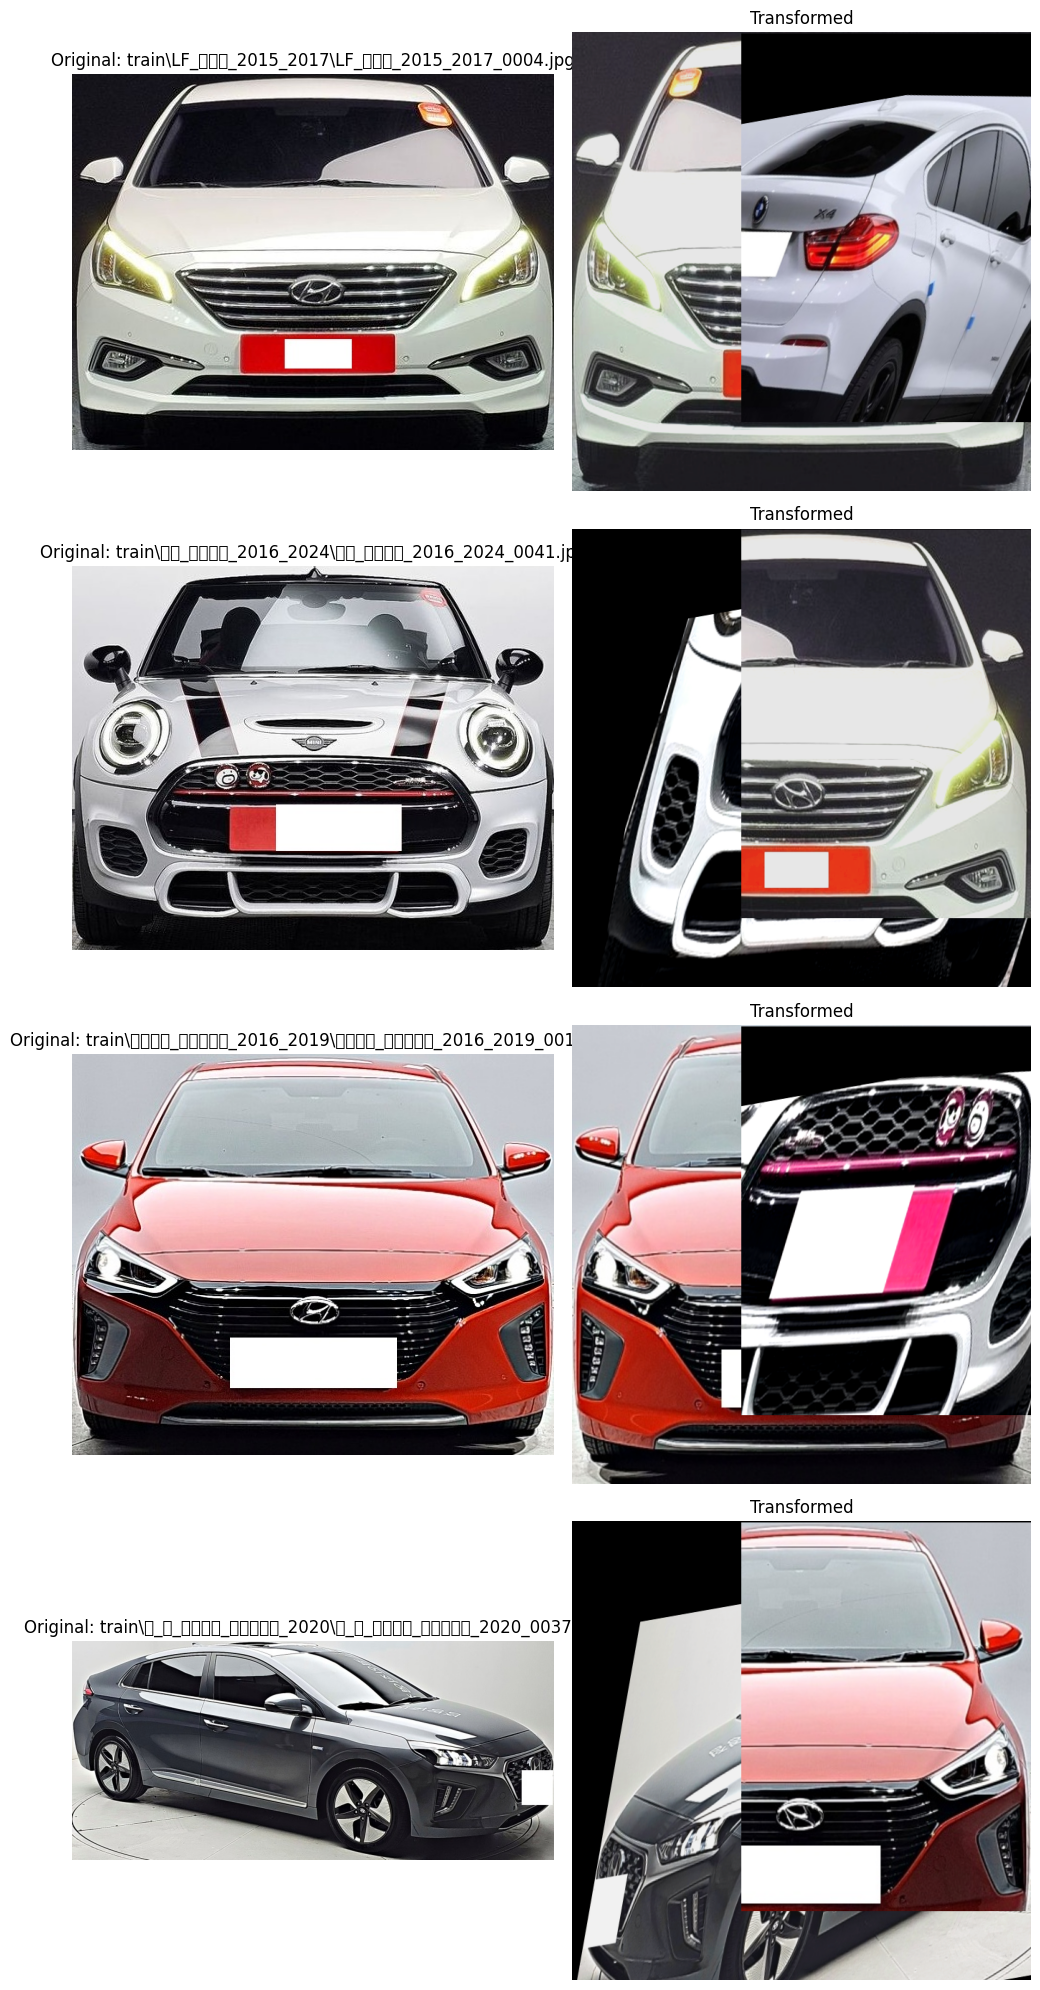

In [12]:
show_transformed_vs_original(train_loader)